# 从全连接到卷积

- 原则1：平移不变性
- 原则2：局部性


总结：对全连接层使用平移不变性和局部性得到卷积层

## 卷积层

二维交叉相关

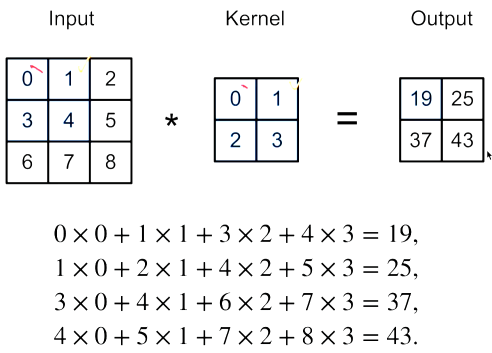

二维卷积层

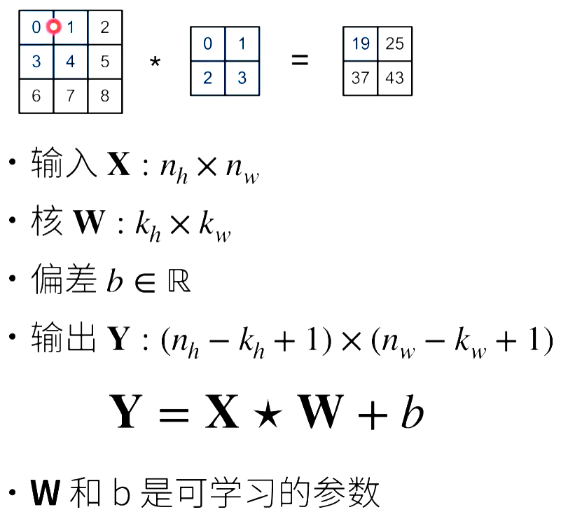

总结
- 卷积层将输入和核矩阵进行交叉相关，加上偏移后得到输出
- 核矩阵和偏移是可学习的参数
- 核矩阵的大小是超参数(kernel_size)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K): #@save
    """
    计算二维互相关运算
    """
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1]- w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i+ h, j: j+ w] * K).sum()
    return Y

In [3]:
Y = torch.tensor([[0.0, 1.0, 2.0], 
                  [3.0, 4.0, 5.0],
                  [6.0, 7.0 ,8.0]])

K = torch.tensor([[0.0, 1.0],
                  [2.0, 3.0]])
corr2d(Y, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
#构造卷积层实例
class Conv2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, X):
        #调用上述互相关计算函数，得到卷积层的输出
        return corr2d(X, self.weight) +self.bias

In [5]:
#应用：图像中的目标边缘检测
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])


tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [6]:
#将X转置，之前检测的垂直边缘消失
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [7]:
#通过仅查看“输入-输出”来学习由X生成Y的卷积核
#构建一个二维卷积层，具有一个输出通道和形状为(1, 2)的卷积核
conv2d = nn.Conv2d(in_channels= 1, out_channels= 1, kernel_size=(1, 2), bias= False)
#(B, C, H, W)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat- Y) ** 2
    conv2d.zero_grad()
    #反向传播
    l.sum().backward()
    #迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1} , loss {l.sum(): .3f}')

epoch 2 , loss  17.632
epoch 4 , loss  5.952
epoch 6 , loss  2.225
epoch 8 , loss  0.876
epoch 10 , loss  0.353


In [8]:
print(conv2d.weight.data)
conv2d.weight.data.reshape((1, 2))

tensor([[[[ 0.9271, -1.0490]]]])


tensor([[ 0.9271, -1.0490]])

## 填充和步幅

填充
- 在输入周围添加额外的行/列

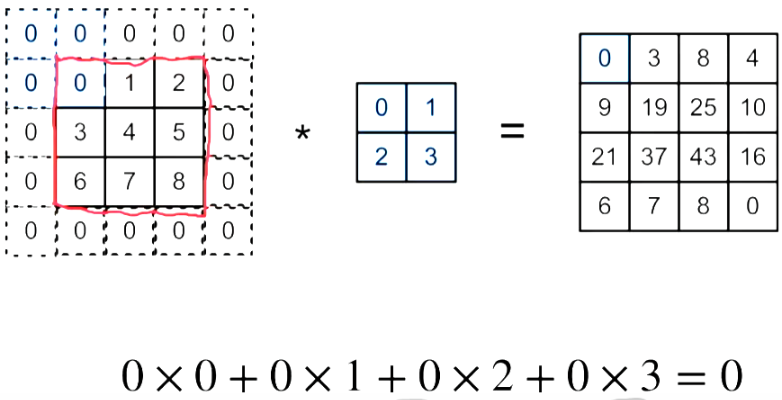

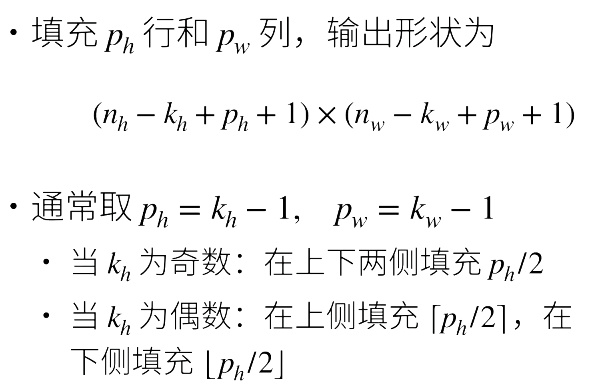

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5等

选择奇数的好处是：保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

步幅
- 填充减小的输出大小与层线性相关
  - 给定输入大小224* 224，在使用5*5卷积核的情况下，需要55层将输出降低到4 * 4
  - 需要大量计算才能减小输出

步幅
- 步幅是指行/列的滑动步长
  - 例：高度3 宽度2的步幅

总结
- 填充和步幅是卷积层的超参数
- 填充在输入周围添加额外的行/列，来控制输出形状的减少量
- 步幅是每次滑动核窗口时的行/列的步长，可以成倍的减少输出形状

In [12]:
#定义一个计算卷积层的函数
def comp_conv2d(conv2d, X):
    #改变张量形状，添加输入通道和输出通道。
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    #忽略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size= 3, padding= 1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
#当卷积核的高度和宽度不同时，可以填充不同的高度和宽度，使输出和输入有相同的高度和宽度。
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [15]:
#步幅为2
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [16]:
#一个稍微复杂的例子
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])